# Lab1: Binary image classifier

## 1. Setup
Install fastbook and setup Google drive connection.

In [6]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

Import necessary libraries

In [7]:
from fastbook import * # this will import search_images_ddg() which does not work for me
from fastai.vision.widgets import *

## 2. Download images 
Use Azure image search or DuckDuckGo to download 150 images of each class. Save images to Google drive.

In [13]:
export_path = Path('/content/gdrive/MyDrive/Colab Notebooks/')

phone_types = 'samsung','apple'
path = export_path/'smartphones_ddg' #ddg = duckduckgo

export_path.ls()

(#0) []

### 2.1 Try it out
Similar to the lecture notebook, try out your query and plot a few of the resulting images to verify that your search returns sensible images.

0: https://www.mobile57.com/og-site-imgs/apple.jpg
1: http://www.cellularcountry.com/images/Apple_iPhone_4s_8GB_Smartphone_-_Unlocked_GSM_-_Black_51796_03.jpg
2: https://images.esellerpro.com/2131/I/248/074/lrgscaleIMG_6298.JPEG
3: https://i.ebayimg.com/images/g/zzMAAOSwvqhdpvmh/s-l1600.jpg
4: http://d3d71ba2asa5oz.cloudfront.net/12021148/images/me5s1.jpg
5: https://www.cellularcountry.com/images/Apple_iPhone_5_32GB_Smartphone_-_Unlocked_GSM_-_White_51848_05.jpg
6: http://img.bidallies.com/images/cp/Apple-iPhone5C-16GB-ATT-Blue-2.jpg
7: https://s3.amazonaws.com/images.ecwid.com/images/37743952/1695456099.jpg
8: https://www.reaganwireless.com/wp-content/uploads/2018/06/product_i_p_iphone_5s_1.jpg
9: https://static.highsnobiety.com/thumbor/vOi8VlH-zjsWIoq-WH57ztT2URI=/1600x1067/static.highsnobiety.com/wp-content/uploads/2020/05/15160007/apple-iphone-flip-concept-01.jpg
10: https://content.propertyroom.com/listings/sellers/seller888888921/images/origimgs/att-apple-iphone-4-8gb-smartphone-

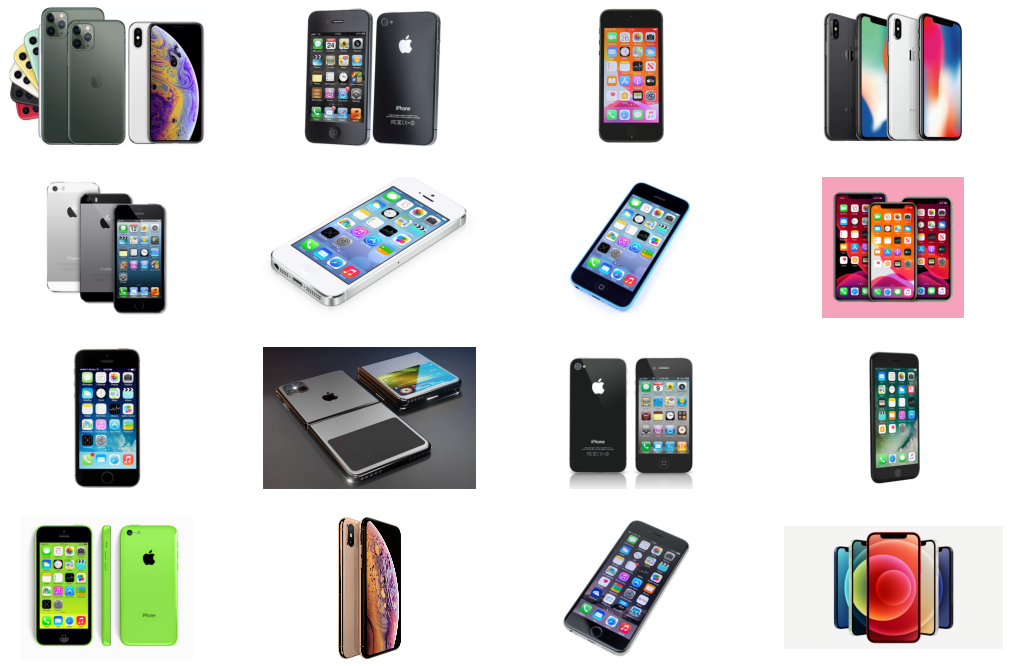

In [15]:
urls = search_images_ddg('apple smartphones', max_images=100)

f, axes = plt.subplots(4, 4, figsize=(18,12))
axes = axes.flatten()
ax_i = 0
img_i = 0
while ax_i < len(axes) and img_i < len(urls):
    try:
      url = urls[img_i]
      print(f'{img_i}: {url}')
      image_data = requests.get(url)
      image_data.raise_for_status()
      
      image = Image.open(BytesIO(image_data.content)) 
      axes[ax_i].imshow(image)
      axes[ax_i].axis("off")
      ax_i += 1 # next axis
    except requests.exceptions.RequestException as e:
      print(e)
    finally:
      img_i += 1 # next image, especially when exception occured

      
plt.show()

0: https://www.unlockunit.com/blog/wp-content/uploads/2015/06/Samsung-Galaxy-Nexus.jpg
1: https://edgvio.com/wp-content/uploads/2020/10/5f99bb773d3a5.jpg
2: http://2.bp.blogspot.com/-CyhKXTZd2Hc/UQtw4hG03jI/AAAAAAAABck/ukan6Y75Ea0/s1600/samsung.jpg
3: http://www.wired.com/wp-content/uploads/2016/02/GalaxyS7edge-lead.jpg
4: https://i-cdn.phonearena.com/images/phones/31878-xlarge/Samsung-Stratosphere.jpg
5: http://phoneradar.com/wp-content/uploads/2017/01/Samsung-Galaxy-J2-Ace.png
6: https://en.letsgodigital.org/uploads/2019/02/galaxy-smartphone.jpg
7: https://vietnamtimes.org.vn/stores/news_dataimages/phuonglyvnt/082020/14/18/0415_samsung-2020-smartphone.jpg?rt=20200815070913
8: https://cdn1.expertreviews.co.uk/sites/expertreviews/files/2019/02/best_samsung_phone_galaxy_smartphones.jpg
9: https://en.letsgodigital.org/uploads/2019/02/samsung-foldable-smartphone.jpg
10: https://www.sammobile.com/wp-content/uploads/2021/01/Galaxy-S21-Ultra-review-19.jpg
11: https://m-cdn.phonearena.com/ima

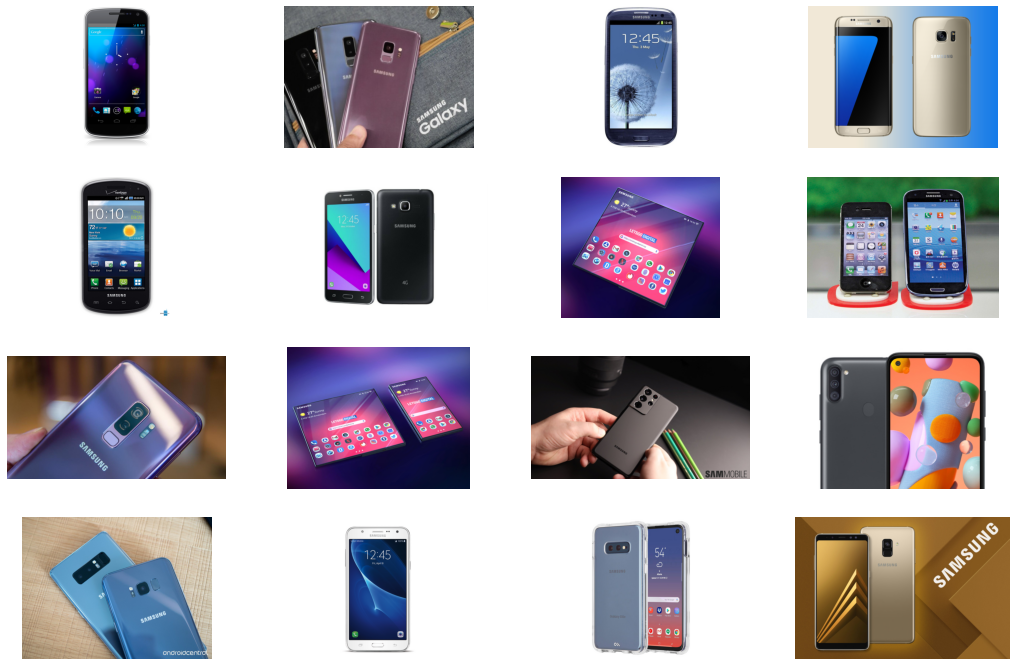

In [16]:
urls = search_images_ddg('samsung smartphones', max_images=100)

f, axes = plt.subplots(4, 4, figsize=(18,12))
axes = axes.flatten()
ax_i = 0
img_i = 0
while ax_i < len(axes) and img_i < len(urls):
    try:
      url = urls[img_i]
      print(f'{img_i}: {url}')
      image_data = requests.get(url)
      image_data.raise_for_status()
      
      image = Image.open(BytesIO(image_data.content)) 
      axes[ax_i].imshow(image)
      axes[ax_i].axis("off")
      ax_i += 1 # next axis
    except requests.exceptions.RequestException as e:
      print(e)
    finally:
      img_i += 1 # next image, especially when exception occured

      
plt.show()

### 2.2 Get images for the two classes
Download 150 images of each class. Save images to Google drive.  
Remove any corrupt images using `verify_images()`.

In [27]:
if not path.exists():
    path.mkdir()
    for o in phone_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} smartphone',max_images=150) #grabs "about" 150 images
        download_images(dest, urls=results)

In [28]:
#removing corrupted images 
fns = get_image_files(path)
failed = verify_images(fns)

failed.map(Path.unlink); # map() applies the function to all elements in the list. unlink() deletes the file.
failed #to see if it's working

(#2) [Path('/content/gdrive/MyDrive/Colab Notebooks/smartphones_ddg/samsung/00000108.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/smartphones_ddg/apple/00000012.jpg')]

## 3. Setup image loaders
Setup image loaders, use 20% of images for validation, and show one batch for each training and validation dataset.

In [29]:
phones = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #image->discrete category
    get_items=get_image_files, # path->images
    splitter=RandomSplitter(valid_pct=0.2, seed=42), #how to train-valid split
    get_y=parent_label, # get the label from the directory name
    item_tfms=RandomResizedCrop(224, min_scale=0.5), # random crop at each iteration, resize to 224x224
    batch_tfms=aug_transforms()) #a set of transformations like  rotation, flipping, perspective warping, brightness changes and contrast changes

dls = phones.dataloaders(path)

There are 276 training images
There are 69 validation images


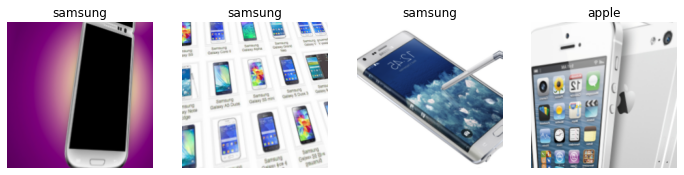

In [30]:
print(f'There are {dls.train.n} training images')
print(f'There are {dls.valid.n} validation images')

dls.train.show_batch(max_n = 4, nrows = 1)

In [32]:
#This block of code is to determine how many images of each category is in the training and validation sets. 
valid_apple = 0;
valid_samsung = 0;
train_apple = 0;
train_samsung =0;

for n in range(dls.valid.n):
  if(dls.valid_ds[n][1] == TensorCategory(0)):
    valid_apple+=1;
  else:
    valid_samsung+=1;

for n in range(dls.train.n):
  if(dls.train_ds[n][1] == TensorCategory(0)):
    train_apple+=1;
  else:
    train_samsung+=1;


print(f'There are {train_apple} apple smartphones images and {train_samsung} samsung smartphone images in the training set')
print(f'There are {valid_apple} apple smartphones images and {valid_samsung} samsung smartphone images in the validation set')

There are 137 apple smartphones images and 139 samsung smartphone images in the training set
There are 35 apple smartphones images and 34 samsung smartphone images in the validation set


In [36]:
dls.valid_ds[1][0]
dls.valid_ds[1][1]
# dls.valid_ds[10][0]
# dls.valid_ds[10][1]

TensorCategory(1)

**Question 1:** How many images of each class are in trainging and validation sets?

There are 137 apple smartphones images and 139 samsung smartphone images in the training set
There are 35 apple smartphones images and 34 samsung smartphone images in the validation set

## 4. Setup cnn learner
Setup a cnn learner with the dataloaders, `resnet18` architecture and `error_rate` as metric.

In [37]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## 5. Train binary classifier
Fine tune for 10 epochs and show results.

In [39]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.960820,0.548241,0.217391,00:18


epoch,train_loss,valid_loss,error_rate,time
0,0.547576,0.484329,0.173913,00:17
1,0.555406,0.425605,0.159420,00:17
2,0.505295,0.364203,0.101449,00:17
3,0.439852,0.352305,0.101449,00:21
4,0.372242,0.379806,0.115942,00:18
5,0.331666,0.407174,0.101449,00:17
6,0.298999,0.399295,0.101449,00:16
7,0.265742,0.379929,0.101449,00:16
8,0.240114,0.361448,0.101449,00:16
9,0.215213,0.356798,0.086957,00:17


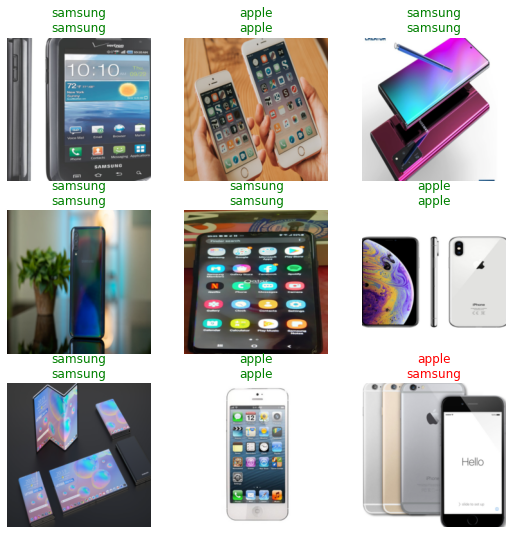

In [40]:
learn.show_results()

**Question 2:** Is the model overfitting? Why, why not?

Error_rate = 0.086957

## 6. Analyze results

Plot confusion matrix.

Plot top 5 losses.


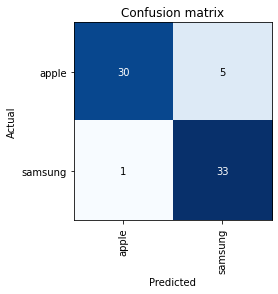

In [41]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

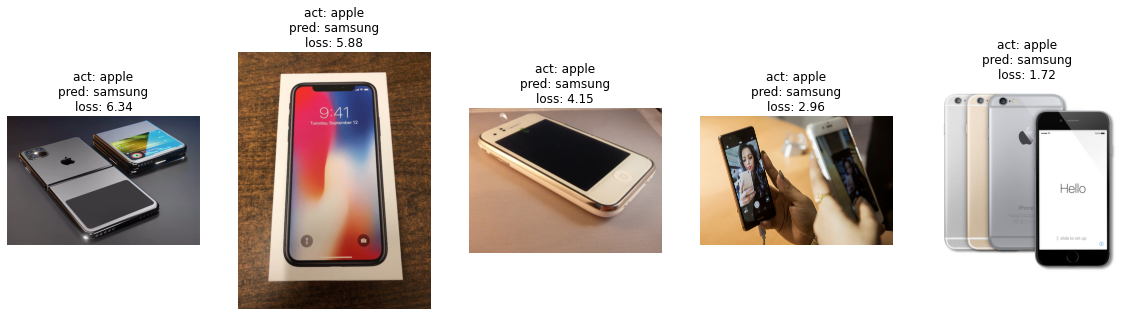

In [42]:
#top 5 losses
k=5
losses, idxs = interp.top_losses(k)
predicteds = interp.preds[idxs].argmax(axis=1)
fig, axs = plt.subplots(nrows=1, ncols=k, figsize=(20, 10))

for ax, id, loss, pred in zip(axs, idxs, losses, predicteds):
    img, actual = dls.valid_ds[id]
    img.show(ctx=ax)
    ax.set_title(f'act: {dls.vocab[actual.item()]}\npred: {dls.vocab[pred]}\nloss: {loss:.2f}')

**Question 3:** How many false positive, false negative errors?

*YOUR ANSWER HERE*

## 7. Summary and Conclusion

Summarize:
- Type of classifier trained.
- Number of images of each class in the training validation sets
- Error rate achieved

*YOUR ANSWER HERE*

Conclusion:
- Are there any problems with data/labeling?
- Are you satisfied with model performance? Why, why not?

*YOUR ANSWER HERE*


## 8. Reflection
Include a sentence or two about 
- what you liked or disliked, 
- found interesting, confusing, challangeing, motivating 

while working on this assignment.

*YOUR ANSWER HERE*